<a href="https://colab.research.google.com/github/natanlubman/studies_ML/blob/main/ML_ex3_GuyKornblit_308224948.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 – Aim: ANN from Scratch (40 Points)

1. Read chapter 11: “Implementing a Multi-layer Artificial Neural Network from Scratch” of the book “Machine Learning with PyTorch and Scikit-Learn” by Raschka et al. (2022)

2. Given the code of chapter 11 that can be found in:
https://github.com/rasbt/machine-learning-book/blob/main/ch11/ch11.ipynb
your main goal is to extend the code to address two hidden layers (instead of a single hidden layer). Extend the code by creating a local copy of the ch11.
ipynb, perform the revisions, and submit the GitHub link to your revised code.


3. Apply the code of section 2 with the two layers for classifying handwritten digits MNIST dataset using the same full ANN architecture presented in the class (see “Solution 1: A plain deep NN”) and evaluate its prediction performance (macro AUC) using Train(70%)/Test(30%) validation procedure. 


In [ ]:
import os 
import random
import numpy as np 
import tensorflow as tf
import torch

def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    tf.random.set_seed(seed)    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(123)

## Load MNIST data

In [ ]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
X = ((X / 255.) - .5) * 2

y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  test_size=0.3, 
                                                  random_state=123, 
                                                  stratify=y)

# optional to free up some memory by deleting non-used arrays:
del X, y

In [ ]:
NUM_FEATURES = 28 * 28
NUM_HIDDEN = 50
NUM_CLASSES = 10
NUM_EPOCHS = 50
BATCH_SIZE = 100
LR = 0.1

## Methods for training

In [ ]:
import numpy as np

def minibatch_generator(X, y, BATCH_SIZE):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - BATCH_SIZE + 1, BATCH_SIZE):
        batch_idx = indices[start_idx:start_idx + BATCH_SIZE]
        yield X[batch_idx], y[batch_idx]

def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=BATCH_SIZE):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        probas = nnet.forward(features)[-1]
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
def sanity_check(model, X_valid, y_valid):
    probas = model.forward(X_valid)[-1]
    mse = mse_loss(y_valid, probas)

    predicted_labels = np.argmax(probas, axis=1)
    acc = accuracy(y_valid, predicted_labels)

    print(f'Initial validation MSE: {mse:.1f}')
    print(f'Initial validation accuracy: {acc*100:.1f}%')

In [ ]:
def train_single_layer(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, BATCH_SIZE)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc



def train_two_layers(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, BATCH_SIZE)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            (d_loss__d_w_out, d_loss__d_b_out, 
            d_loss__d_w_h1, d_loss__d_b_h1,
            d_loss__d_w_h2, d_loss__d_b_h2) = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [ ]:
import matplotlib.pyplot as plt
def plot_MSE(epoch_loss, title):
    plt.plot(range(len(epoch_loss)), epoch_loss)
    plt.ylabel('Mean squared error')
    plt.xlabel('Epoch')
    #plt.savefig('figures/11_07.png', dpi=300)
    plt.title(title)
    plt.show()

def plot_accuracy(epoch_train_acc, epoch_valid_acc, title):
    plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
            label='Training')
    plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
            label='Validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='lower right')
    plt.title(title)
    plt.show()

## Model Implementation

In [ ]:
import numpy as np

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

class TwoLayersMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h1 = rng.normal(
        loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h1 = np.zeros(num_hidden)

        self.weight_h2 = rng.normal(
        loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_h2 = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
        loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)


    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Second Hidden Layer
        # input dim: [n_examples, n_hidden] dot [num_hidden2, n_hidden].T
        # output dim: [n_examples, num_hidden2]
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        # input dim: [n_examples, num_hidden2] dot [n_classes, num_hidden2].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):  

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, num_hidden2]
        d_z_out__dw_out = a_h2

        # input dim: [n_examples, n_classes].T dot [n_examples, num_hidden2]
        # output dim: [n_classes, num_hidden2]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #################################        
        # Part 2: dLoss/dHiddenWeights of layer h2
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, num_hidden2]
        d_z_out__d_a_h2 = self.weight_out

        # Input: [n_examples, n_classes] dot [n_classes, num_hidden2]
        # output dim: [n_examples, num_hidden2]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__d_a_h2)

        # [n_examples, num_hidden2]
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative

        # [n_examples, n_hidden]
        d_z_h2__d_w_h2 = a_h1

        # Input: [n_examples, num_hidden2] * [n_examples, num_hidden2]
        # output dim: [n_examples, num_hidden2]
        d_loss__d_z_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

        # Input: [n_examples, num_hidden2].T dot [n_examples, n_hidden]
        # output dim: [num_hidden2, n_hidden]
        d_loss__d_w_h2 = np.dot(d_loss__d_z_h2.T, d_z_h2__d_w_h2)
        d_loss__d_b_h2 = np.sum(d_loss__d_z_h2, axis=0)

        #################################        
        # Part 2: dLoss/dHiddenWeights of layer h1
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [num_hidden2, n_hidden]
        d_z_h2__d_a_h1 = self.weight_h2

        # [n_examples, n_hidden]
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1) # sigmoid derivative

        # Input: [n_examples, num_hidden2] @ [num_hidden2, n_hidden] * [n_examples, n_hidden]
        # output dim: [n_examples, n_hidden]
        d_loss__d_z_h1 = (d_loss__d_z_h2 @ d_z_h2__d_a_h1) * d_a_h1__d_z_h1
        
        # [n_examples, n_features]
        d_z_h1__d_w_h1 = x
        
        # Input dim: [n_examples, n_hidden].T dot [n_examples, n_features]
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h1 = np.dot(d_loss__d_z_h1.T, d_z_h1__d_w_h1)
        d_loss__d_b_h1 = np.sum(d_loss__d_z_h1, axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h1, d_loss__d_b_h1,
                d_loss__d_w_h2, d_loss__d_b_h2)

In [ ]:
two_layers_model = TwoLayersMLP(num_features=NUM_FEATURES,
                                num_hidden=NUM_HIDDEN,
                                num_classes=NUM_CLASSES)

sanity_check(two_layers_model, X_test, y_test)

Initial validation MSE: 0.2
Initial validation accuracy: 9.0%


In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train_two_layers(two_layers_model, 
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_epochs=NUM_EPOCHS, 
                                                                learning_rate=LR)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 21.29% | Valid Acc: 21.53%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 23.40% | Valid Acc: 23.33%
Epoch: 003/050 | Train MSE: 0.08 | Train Acc: 33.60% | Valid Acc: 33.36%
Epoch: 004/050 | Train MSE: 0.06 | Train Acc: 59.08% | Valid Acc: 58.91%
Epoch: 005/050 | Train MSE: 0.05 | Train Acc: 66.51% | Valid Acc: 66.46%
Epoch: 006/050 | Train MSE: 0.04 | Train Acc: 77.70% | Valid Acc: 77.58%
Epoch: 007/050 | Train MSE: 0.03 | Train Acc: 83.58% | Valid Acc: 83.26%
Epoch: 008/050 | Train MSE: 0.03 | Train Acc: 86.68% | Valid Acc: 86.39%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 87.80% | Valid Acc: 87.67%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 88.56% | Valid Acc: 88.29%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 89.33% | Valid Acc: 88.99%
Epoch: 012/050 | Train MSE: 0.02 | Train Acc: 89.81% | Valid Acc: 89.48%
Epoch: 013/050 | Train MSE: 0.02 | Train Acc: 90.14% | Valid Acc: 89.74%
Epoch: 014/050 | Train MSE: 0.02 | Train Acc: 90.57

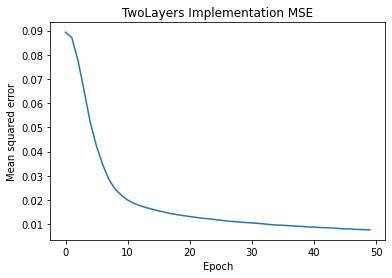

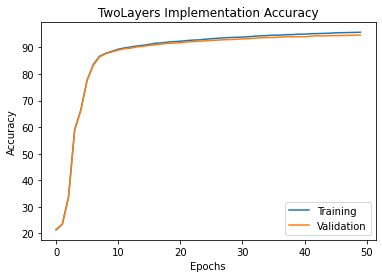

In [ ]:
plot_MSE(epoch_loss, "TwoLayers Implementation MSE")
plot_accuracy(epoch_train_acc, epoch_valid_acc, "TwoLayers Implementation Accuracy")

In [ ]:
test_mse, test_acc = compute_mse_and_acc(two_layers_model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.69%


## 2-layers MLP Evaluation
Apply the code of section 2 with the two layers for classifying handwritten digits MNIST dataset using the same full ANN architecture presented in the class (see “Solution 1: A plain deep NN”) and evaluate its prediction performance (macro AUC) using Train(70%)/Test(30%) validation procedure. 
Compare the predictive performance of section 3 with the original (single hidden layer) code and with the fully connected ANN implemented in Keras/TensorFlow/PyTorch (choose one).

## Original Single Layer Model from Git

In [ ]:
class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [ ]:
single_model = NeuralNetMLP(num_features=NUM_FEATURES,
                     num_hidden=NUM_HIDDEN,
                     num_classes=NUM_CLASSES)

sanity_check(single_model, X_test, y_test)

Initial validation MSE: 0.3
Initial validation accuracy: 9.2%


In [ ]:
epoch_loss, epoch_train_acc, epoch_valid_acc = train_single_layer(single_model, 
                                                                  X_train, y_train, 
                                                                  X_test, y_test, 
                                                                  num_epochs=NUM_EPOCHS, 
                                                                  learning_rate=LR)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 75.22% | Valid Acc: 75.13%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 84.59% | Valid Acc: 84.48%
Epoch: 003/050 | Train MSE: 0.03 | Train Acc: 87.40% | Valid Acc: 87.31%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 88.87% | Valid Acc: 88.64%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 89.79% | Valid Acc: 89.58%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.37% | Valid Acc: 90.18%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 90.82% | Valid Acc: 90.66%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.21% | Valid Acc: 91.01%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 91.48% | Valid Acc: 91.32%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 91.72% | Valid Acc: 91.60%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 91.98% | Valid Acc: 91.80%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.12% | Valid Acc: 91.85%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.32% | Valid Acc: 92.07%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.52

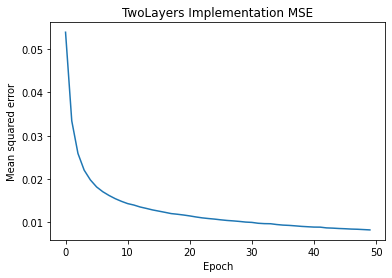

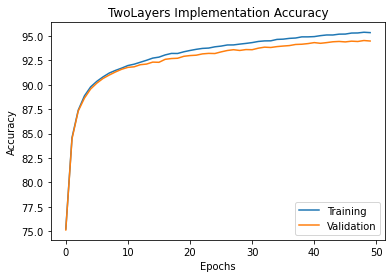

In [ ]:
plot_MSE(epoch_loss, "TwoLayers Implementation MSE")
plot_accuracy(epoch_train_acc, epoch_valid_acc, "TwoLayers Implementation Accuracy")

In [ ]:
test_mse, test_acc = compute_mse_and_acc(two_layers_model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.69%


## TF Two Layers MLP

In [ ]:
import tensorflow as tf
tf_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(NUM_FEATURES,)),
  tf.keras.layers.Dense(NUM_HIDDEN, activation='sigmoid'),
  tf.keras.layers.Dense(NUM_HIDDEN, activation='sigmoid'),
  tf.keras.layers.Dense(NUM_CLASSES)
])
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

tf_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LR),
              loss=loss_fn,
              metrics=['accuracy'])

tf_model.fit(X_train, y_train,
          validation_data=(X_test, y_test), 
          epochs=NUM_EPOCHS, 
          batch_size=BATCH_SIZE)

Epoch 1/50
490/490 [==============================] - 3s 5ms/step - loss: 1.5081 - accuracy: 0.6273 - val_loss: 0.7800 - val_accuracy: 0.8252
Epoch 2/50
490/490 [==============================] - 2s 5ms/step - loss: 0.5710 - accuracy: 0.8643 - val_loss: 0.4585 - val_accuracy: 0.8830
Epoch 3/50
490/490 [==============================] - 2s 4ms/step - loss: 0.4001 - accuracy: 0.8937 - val_loss: 0.3698 - val_accuracy: 0.9004
Epoch 4/50
490/490 [==============================] - 2s 4ms/step - loss: 0.3355 - accuracy: 0.9069 - val_loss: 0.3279 - val_accuracy: 0.9083
Epoch 5/50
490/490 [==============================] - 2s 4ms/step - loss: 0.2964 - accuracy: 0.9157 - val_loss: 0.2931 - val_accuracy: 0.9169
Epoch 6/50
490/490 [==============================] - 2s 4ms/step - loss: 0.2683 - accuracy: 0.9224 - val_loss: 0.2711 - val_accuracy: 0.9211
Epoch 7/50
490/490 [==============================] - 2s 4ms/step - loss: 0.2461 - accuracy: 0.9298 - val_loss: 0.2478 - val_accuracy: 0.9280
Epoch 

## Compare Models on Macro AUC

In [ ]:
import pandas as pd
def stable_softmax(X):
    exps = np.exp((X.T - np.max(X, axis=1)).T)
    return (exps.T / (np.sum(exps, axis=1))).T

In [ ]:
from sklearn.metrics import roc_auc_score
two_layers_pred = stable_softmax(two_layers_model.forward(X_test)[-1])
single_pred = stable_softmax(single_model.forward(X_test)[-1])
tf_pred = tf.keras.Sequential([tf_model, tf.keras.layers.Softmax()]).predict(X_test)

In [ ]:
two_auc = roc_auc_score(y_test, two_layers_pred, multi_class='ovr')
single_auc = roc_auc_score(y_test, single_pred, multi_class='ovr')
tf_auc = roc_auc_score(y_test, tf_pred, multi_class='ovr')
pd.DataFrame([two_auc, single_auc, tf_auc], index=['custom_two_layers', 'custom_single_layer', 'tf_two_layer'])

,0
custom_two_layers,0.996590
custom_single_layer,0.996312
tf_two_layer,0.999011


# Part 2 (60 points) - Aim: Practice the usage of CNN (Convolutional Neural Network). 

* In this part you will use at least two pretrained CNNs to identify the type of a flower that appears in an image. You will need to choose your pretrained models and use Transfer Learning to associate flower images into their corresponding categories.

We would like the model to classify the image into its category (the dandelions category in this example). The model should be probabilistic and returns the probability of a flower belonging to each of the categories.


In [ ]:
# Mount our shared Folder in Drive
base_path = "/content/drive/MyDrive/MastersDegree/ML/ex3/data"
# base_path = # Natan Path in Drive

In [ ]:
# Load Data and Labels, Split to train, validation and test.
import scipy.io
mat = scipy.io.loadmat(base_path + '/imagelabels.mat')
mat['labels']

In [ ]:
# Create Train / Test Split
DATA_SIZE = 8189

test_indices = np.random.choice(np.arange(DATA_SIZE), round(0.3 * DATA_SIZE))
train_indices = np.delete(np.arange(DATA_SIZE), test_indices)
# Be better dump this split indices for later use.

In [ ]:
# flowers_df = 
import pathlib
dataset_path = base_path + '/102_flowers.tgz'

data_dir = pathlib.Path(dataset_path)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

In [ ]:
PIL.Image.open(str(roses[0]))


## Stand Alone (Frozen) Feature Extractor

In [ ]:
# example of using the vgg16 model as a feature extraction model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model

# load an image from file
image = load_img('dog.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = preprocess_input(image)

# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# get extracted features
features = model.predict(image)

## Feature Extractor Within Model (Finetune weights)

In [ ]:
# example of tending the vgg16 model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# load model without classifier layers
model = VGG16(include_top=False, input_shape=(300, 300, 3))
# mark loaded layers as not trainable
for layer in model.layers:
	layer.trainable = False
  
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()
# ...

## Important Info and links
* More Data - https://www.tensorflow.org/tutorials/load_data/images
* Model (and datasets?) - [hugging face](https://huggingface.co)